In [1]:
import pymc as pm
import arviz as az
import numpy as np
import zipfile
import json

import sys
from datetime import datetime
import pkg_resources
from pathlib import Path

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/tmp/ipykernel_21062/1222495334.py:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [8]:
pm.__version__

'5.16.2'

In [2]:
# Unzip the file
with zipfile.ZipFile("posterior_database/data/data/GLM_Poisson_Data.json.zip", 'r') as zip_ref:
    zip_ref.extractall("posterior_database/data/data/")

# Load the JSON file into a Python dictionary
with open("posterior_database/data/data/GLM_Poisson_Data.json", "r") as file:
    data = json.load(file)

data

{'year': [-1.66802789939819,
  -1.58248800712136,
  -1.49694811484453,
  -1.4114082225677,
  -1.32586833029087,
  -1.24032843801404,
  -1.15478854573721,
  -1.06924865346038,
  -0.983708761183547,
  -0.898168868906717,
  -0.812628976629887,
  -0.727089084353056,
  -0.641549192076226,
  -0.556009299799396,
  -0.470469407522566,
  -0.384929515245736,
  -0.299389622968906,
  -0.213849730692075,
  -0.128309838415245,
  -0.0427699461384151,
  0.0427699461384151,
  0.128309838415245,
  0.213849730692075,
  0.299389622968906,
  0.384929515245736,
  0.470469407522566,
  0.556009299799396,
  0.641549192076226,
  0.727089084353056,
  0.812628976629887,
  0.898168868906717,
  0.983708761183547,
  1.06924865346038,
  1.15478854573721,
  1.24032843801404,
  1.32586833029087,
  1.4114082225677,
  1.49694811484453,
  1.58248800712136,
  1.66802789939819],
 'C': [29,
  36,
  19,
  28,
  36,
  29,
  20,
  19,
  35,
  32,
  34,
  34,
  33,
  47,
  48,
  46,
  46,
  49,
  60,
  64,
  87,
  85,
  85,
  95

In [3]:
def model(data):
    years_data = np.array(data["year"])
    counts_data = np.array(data["C"])
    number_observations = data['n']
    coords = {
        "features": ['years', 'years**2', 'years**3'],
        'observation': np.arange(number_observations),
    }
    with pm.Model(coords=coords) as pymc_model:

        alpha = pm.Uniform('alpha', -20, +20)
        beta = pm.Uniform('beta', -10, +10, dims="features")
        X = pm.Data('X', np.column_stack([years_data, years_data**2, years_data**3]), dims=['observation', 'feature'])
        y = pm.Data('y', counts_data, dims='observation')
        
        log_lambda = pm.Deterministic('log_lambda', alpha + X @ beta, dims='observation')

        counts = pm.Poisson('counts', mu=pm.math.exp(log_lambda), observed=y, dims='observation')

    return pymc_model

In [4]:
with model(data) as poisson_glm_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'log_lambda'}>,
        <Axes: title={'center': 'log_lambda'}>]], dtype=object)

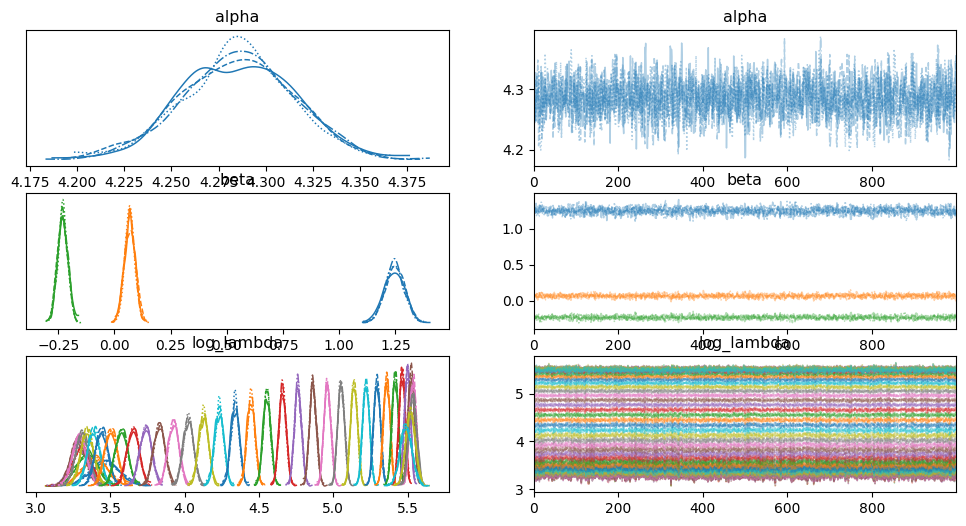

In [6]:
az.plot_trace(trace)